# Code Begins Here:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch import autograd
import torch.nn.functional as F

Importing and Preparing Data

In [6]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
label_ids,count=np.unique(labels,return_counts=True)
print(label_ids,count)


(array([0, 1, 2, 3, 4], dtype=uint8), array([10000, 10000, 10000, 10000, 10000]))


In [13]:
shape_images_flat=(images.shape[0],images.shape[1]*images.shape[2])
images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images)):
    images_normal[index]=((images[index]-images[index].mean())/images[index].std()).flat

#  braking data set into train,validation and test sets
train_images=images_normal[0:40000]
train_labels=labels[0:40000]

validation_images=images_normal[40000:45000]
validation_labels=labels[40000:45000]

test_images=images_normal[45000:50000]
test_labels=labels[45000:50000]



In [21]:
HEIGHT,WIDTH=26,26
NUM_CLASSES=5
batch_size=10
NUM_OPT_STEPS=2000
learning_rate=1e-3

In [22]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super(TooSimpleConvNN,self).__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
    

In [23]:
model=TooSimpleConvNN()
print(model)

TooSimpleConvNN (
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (final_conv): Conv2d(16, 5, kernel_size=(1, 1), stride=(1, 1))
)


In [24]:
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


In [25]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_images[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    
    optimizer.step()
    return loss.data[0]


In [26]:
def accuracy(y, y_hat):
    a=(y==y_hat)
    return a.astype(np.float).mean()

In [27]:
def approx_accuracy(curr_images,curr_labels,length=-1):
    if length==-1:
        length=len(curr_images)
        
    shuffle_list=np.random.choice(len(curr_images), length)
    shuffled_images=curr_images[shuffle_list]
    shuffled_labels=curr_labels[shuffle_list]
    
    x = autograd.Variable(torch.from_numpy(shuffled_images.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(shuffled_labels.astype(np.int)))
    _,y_hat =torch.max(model(x),1)
    # print(y_hat.size())
    return accuracy(y.data.numpy(), y_hat.data.numpy())
         

In [28]:
train_accs, val_accs = [], [] 
for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 100 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
        print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))


     0  0.18  0.20
   100  0.21  0.22
   200  0.21  0.20
   300  0.41  0.43
   400  0.40  0.37
   500  0.52  0.50
   600  0.60  0.58
   700  0.60  0.56
   800  0.61  0.59
   900  0.63  0.63
  1000  0.66  0.65
  1100  0.62  0.62
  1200  0.65  0.66
  1300  0.66  0.66
  1400  0.63  0.64
  1500  0.65  0.64
  1600  0.65  0.67
  1700  0.65  0.67
  1800  0.65  0.66
  1900  0.64  0.67


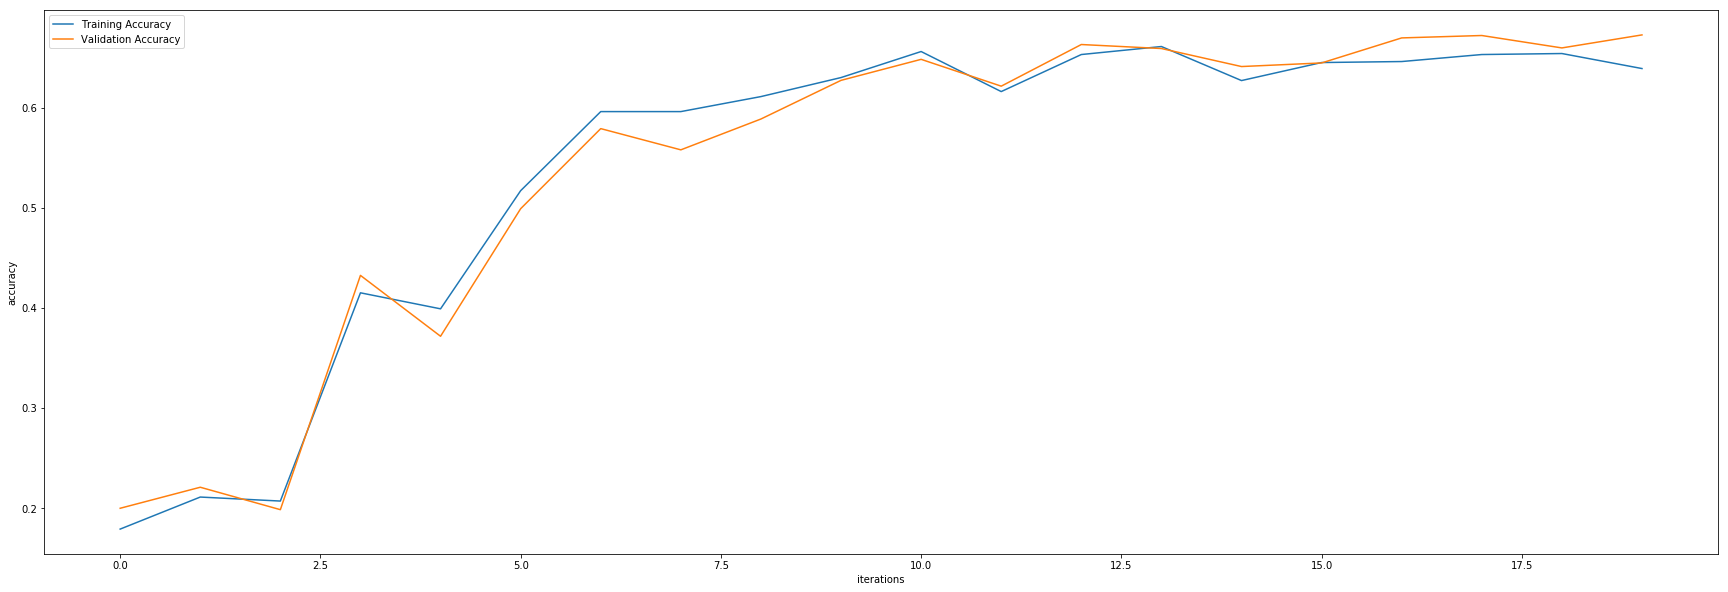

In [29]:
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

## Experimentation

In [57]:
batch_size=60
NUM_OPT_STEPS=20000
# NUM_OPT_STEPS=train_labels.shape[0]/batch_size
learning_rate=1e-3
model=TooSimpleConvNN()
print(model)

TooSimpleConvNN (
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (final_conv): Conv2d(16, 5, kernel_size=(1, 1), stride=(1, 1))
)


In [58]:
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


In [59]:
train_accs, val_accs = [], [] 
for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 100 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
        if i%1000==0:
            print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))


     0  0.20  0.19
  1000  0.70  0.69
  2000  0.70  0.71
  3000  0.72  0.70
  4000  0.74  0.74
  5000  0.72  0.74
  6000  0.77  0.76
  7000  0.75  0.77
  8000  0.79  0.76
  9000  0.78  0.78
 10000  0.80  0.79
 11000  0.78  0.79
 12000  0.77  0.79
 13000  0.77  0.81
 14000  0.81  0.81
 15000  0.80  0.82
 16000  0.79  0.82
 17000  0.80  0.81
 18000  0.82  0.82
 19000  0.80  0.81


 19999  0.82  0.81


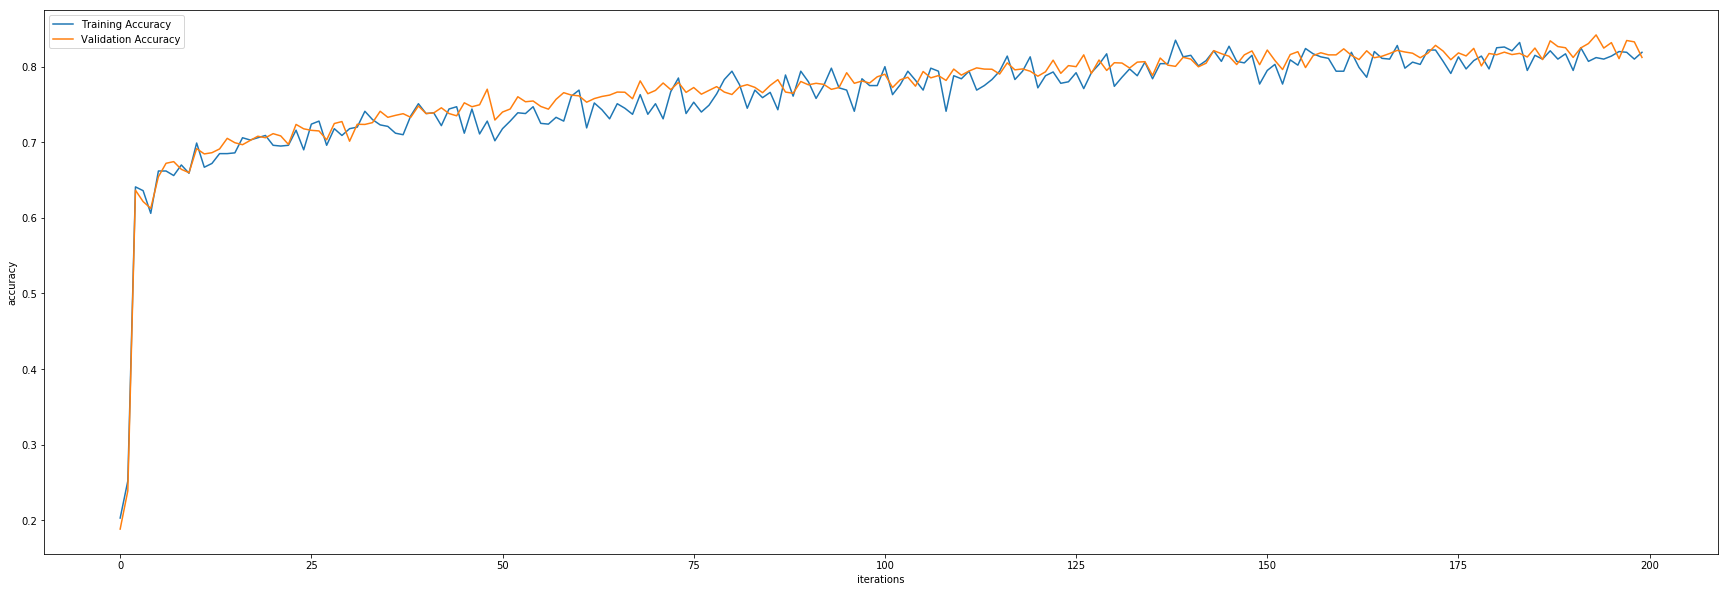

In [60]:
print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

# Highest train and validation accuracies obtained in Simple-Conv-NN 
The train and validation accuracies obtained were : 0.81 0.81

batch_size=60
NUM_OPT_STEPS=20000
learning rate=1e-3